<a href="https://colab.research.google.com/github/RafaelPersano/Flowisetutorial/blob/main/GDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bem-vindo ao simulador de desenvolvimento econômico!
Digite o nome do país: Brasil
Digite os recursos disponíveis (em bilhões): 2000
Digite a dívida bruta do país (em bilhões): 800
Digite a taxa de juros da dívida (anual, em %): 10
Digite a taxa Selic (anual, em %): 12
Digite a população do país (em milhões): 240

50% dos recursos (1000.00 bilhões) serão usados para folha de pagamento.
Recursos restantes para alocação: 920.00 bilhões.

Setores disponíveis: education, health, technology, infrastructure, environment, agriculture
Quanto deseja alocar para education (em bilhões)? 150
Quanto deseja alocar para health (em bilhões)? 120
Quanto deseja alocar para technology (em bilhões)? 150
Quanto deseja alocar para infrastructure (em bilhões)? 180
Quanto deseja alocar para environment (em bilhões)? 50
Quanto deseja alocar para agriculture (em bilhões)? 180

Por quantos anos deseja simular? 10

Simulando ano 1...

Relatório de desenvolvimento do país: Brasil
PIB atual: 1095.72 bilhões
Recurso

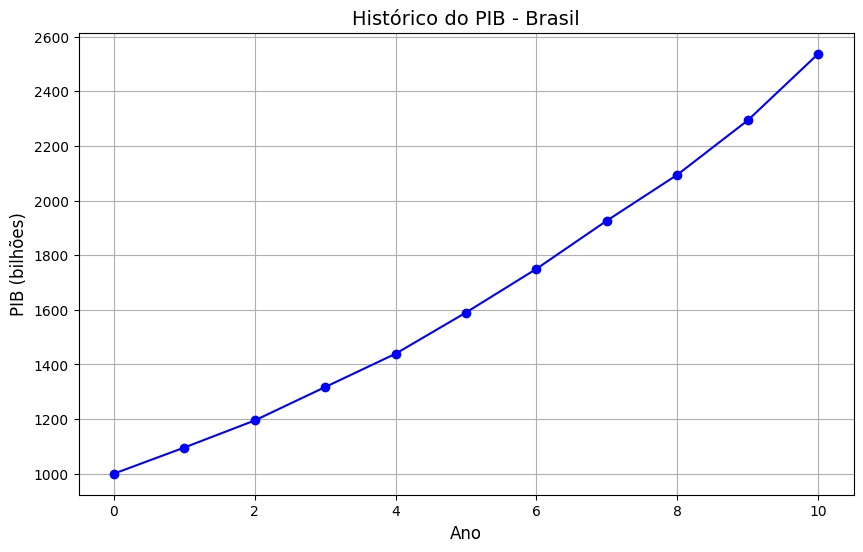

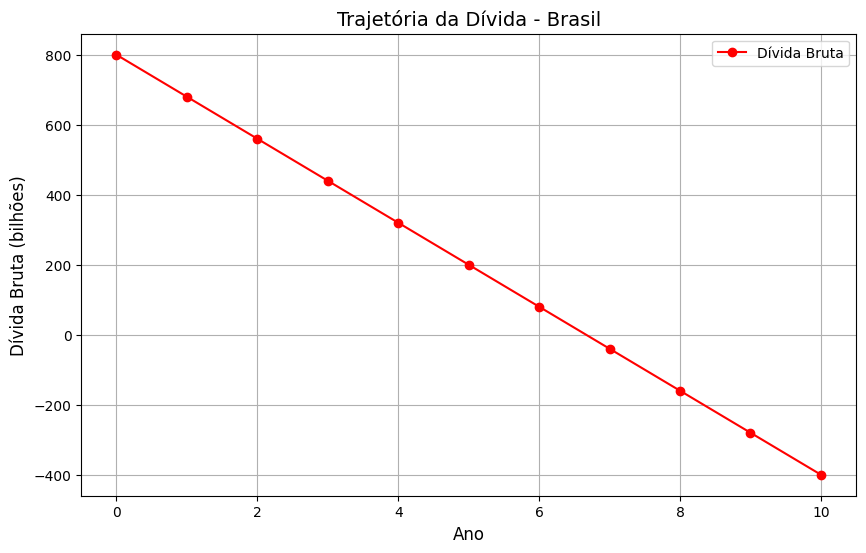

Não há dados suficientes para plotar a contribuição dos setores.


In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np

class CountryDevelopment:
    def __init__(self, name, resources, gross_debt, debt_interest, selic_rate, population):
        self.name = name
        self.resources = resources
        self.gross_debt = gross_debt
        self.debt_interest = debt_interest
        self.selic_rate = selic_rate
        self.public_payroll = 0.5 * resources
        self.debt_payment = self.gross_debt * (self.debt_interest / 100)
        self.remaining_resources = resources - self.public_payroll - self.debt_payment
        self.sectors = {
            "education": {"investment": 0, "efficiency": 1.0, "growth_rate": 0.02},
            "health": {"investment": 0, "efficiency": 1.0, "growth_rate": 0.015},
            "technology": {"investment": 0, "efficiency": 1.0, "growth_rate": 0.03},
            "infrastructure": {"investment": 0, "efficiency": 1.0, "growth_rate": 0.025},
            "environment": {"investment": 0, "efficiency": 1.0, "growth_rate": 0.01},
            "agriculture": {"investment": 0, "efficiency": 0.8, "growth_rate": 0.02}
        }
        self.gdp = 1000
        self.gdp_history = [self.gdp]
        self.debt_history = [self.gross_debt]
        self.population = population
        self.quality_jobs = 0
        self.economically_active_population = self.population * 0.3
        self.middle_class_population = self.economically_active_population * 0.3  # Middle class is 30% of EAP
        self.per_capita_income = self.gdp / self.population * 1000 if self.population > 0 else 0  # In thousands, handle division by zero
        self.pea_per_capita_income = (self.gdp / self.economically_active_population) * 1000 if self.economically_active_population > 0 else 0  # Handle division by zero
        self.quality_jobs_per_capita_income = 0
        self.middle_class_income = self.pea_per_capita_income * random.uniform(2, 4)  # Middle-class income based on EAP per capita income

    def allocate_resources(self, allocations):
        if sum(allocations.values()) > self.remaining_resources:
            raise ValueError("Erro: Recursos insuficientes para as alocações!")
        for sector, amount in allocations.items():
            if sector in self.sectors:
                self.sectors[sector]["investment"] = amount  # Directly assign the amount
                self.remaining_resources -= amount
            else:
                print(f"Aviso: Setor '{sector}' não reconhecido. A alocação foi ignorada.")

    def simulate_year(self):
        previous_gdp = self.gdp
        previous_debt = self.gross_debt

        # --- Adjusted GDP Growth Calculation (Expenditure Approach) ---
        consumption_growth = random.uniform(0.01, 0.04)  # Consumer spending growth
        investment_growth = self.sectors["infrastructure"]["growth_rate"] + self.sectors["technology"]["growth_rate"]  # Investment growth (infrastructure + technology)
        government_spending_growth = random.uniform(0.005, 0.02)  # Government spending growth

        # --- Trade Balance Calculation (More Aggressive Surplus Targeting) ---
        # Further increased export weights for agriculture and mining
        exports = (self.sectors["agriculture"]["investment"] * self.sectors["agriculture"]["efficiency"] * 0.8  # 80% of agriculture exported
                   + self.sectors["technology"]["investment"] * self.sectors["technology"]["efficiency"] * 0.2  # 20% of technology exported
                   + self.remaining_resources * 0.3 * 0.6)  # Assume 60% of mineral resources are exported (remaining_resources represents minerals)

        imports = self.gdp * random.uniform(0.2, 0.3)  # Assume imports are 20-30% of GDP

        # --- Dynamic Import Adjustment ---
        trade_balance = exports - imports
        while trade_balance < 0 and imports > 0:  # Adjust until trade surplus is achieved or imports reach 0
            imports *= 0.95  # Reduce imports by 5% (adjust this factor as needed)
            trade_balance = exports - imports

        # --- End of Trade Balance Calculation ---

        # --- GDP Growth Calculation (Potential Adjustments) ---
        gdp_growth = (consumption_growth + investment_growth + government_spending_growth + trade_balance / self.gdp)
        gdp_growth += random.uniform(-0.01, 0.01)  # Add some random fluctuation
        gdp_growth = min(gdp_growth, 0.15)  # Capped at 15% for faster potential growth
        gdp_growth = max(gdp_growth, -0.02)  # Minimum limit for negative growth at -2%
        gdp_growth += 0.05  # Increased baseline growth to 0.05 (from 0.03)


        # --- GDP Calculation (Adjusted for Realism) ---
        gdp_growth_factor = 0.7  # Adjust this factor as needed

        agricultural_gdp_contribution = self.sectors["agriculture"]["investment"] * self.sectors["agriculture"]["efficiency"]
        self.gdp += agricultural_gdp_contribution

        self.gdp += self.gdp * gdp_growth * gdp_growth_factor
        self.gdp_history.append(self.gdp)

        # --- End of GDP Growth Calculation ---

        default_risk_reduction = gdp_growth * 0.005
        self.selic_rate -= default_risk_reduction
        self.selic_rate = max(0, self.selic_rate)

        population_growth_rate = random.uniform(0.005, 0.015)
        self.population += self.population * population_growth_rate

        self.economically_active_population = self.population * 0.3

        # --- Job Creation Calculation ---
        jobs_created = self.economically_active_population * gdp_growth * 0.5  # Jobs linked to GDP growth and EAP
        jobs_created += self.sectors["infrastructure"]["investment"] * 0.1  # Jobs created by infrastructure investment
        jobs_created += self.sectors["technology"]["investment"] * 0.15  # Jobs created by technology investment
        self.quality_jobs += jobs_created

        self.gross_debt += self.debt_payment - (self.resources * 0.1)
        self.debt_history.append(self.gross_debt)

        # Real GDP Growth
        real_gdp_growth = (self.gdp - previous_gdp) / previous_gdp if previous_gdp > 0 else gdp_growth  # Handle potential division by zero

        # --- Income and Economic Calculations ---
        inflation_rate = random.uniform(0.01, 0.04)
        self.per_capita_income = (self.gdp / self.population) * (1 + inflation_rate) * 1000 if self.population > 0 else 0  # In thousands, handle division by zero

        # --- Adjusted Middle-Class Income Calculation ---
        eap_per_capita_income = self.gdp / self.economically_active_population * 1000 if self.economically_active_population > 0 else 0
        self.middle_class_income = eap_per_capita_income * random.uniform(2, 4)  # Middle-class income based on EAP's per capita income

        # Quality jobs income is significantly higher than middle-class income
        self.quality_jobs_per_capita_income = self.middle_class_income * random.uniform(2, 4)

        # Business Confidence
        business_confidence = gdp_growth * 100
        business_confidence = max(0, min(100, business_confidence))

        # Business Environment
        business_environment = (self.sectors["infrastructure"]["growth_rate"] + self.sectors["technology"]["growth_rate"]) * 50
        business_environment = max(0, min(100, business_environment))

        # PEA Per Capita Income
        self.pea_per_capita_income = (self.gdp / self.economically_active_population) * 1000 if self.economically_active_population > 0 else 0  # Handle division by zero

        # Debt Change
        debt_change = self.gross_debt - previous_debt

        # Middle Class Population Growth (based on EAP growth)
        middle_class_growth_rate = gdp_growth * 0.8
        self.middle_class_population += self.middle_class_population * middle_class_growth_rate
        self.middle_class_population = min(self.middle_class_population, self.economically_active_population)  # Cap at EAP

        return real_gdp_growth, debt_change, business_confidence, business_environment, jobs_created, trade_balance


    def report(self, business_confidence, business_environment, trade_balance):
        print(f"\nRelatório de desenvolvimento do país: {self.name}")
        print(f"PIB atual: {self.gdp:.2f} bilhões")
        print(f"Recursos remanescentes: {self.remaining_resources:.2f} bilhões")
        print(f"Dívida Bruta: {self.gross_debt:.2f} bilhões")
        print(f"Juros da Dívida (anual): {self.debt_interest:.2f}%")
        print(f"Taxa Selic (anual): {self.selic_rate:.2f}%")
        print(f"População: {self.population:.2f} milhões")
        print(f"População Economicamente Ativa (PEA): {self.economically_active_population:.2f} milhões")
        print(f"Renda Per Capita: {self.per_capita_income:.2f} mil reais/ano")
        print(f"Renda Per Capita da PEA: {self.pea_per_capita_income:.2f} mil reais/ano")
        print(f"Renda Per Capita em Empregos de Qualidade: {self.quality_jobs_per_capita_income:.2f} mil reais/ano")
        print(f"Empregos de Qualidade: {self.quality_jobs:.2f} milhões")
        print(f"População da Classe Média: {self.middle_class_population:.2f} milhões")
        print(f"Renda da Classe Média: {self.middle_class_income:.2f} mil reais/ano")
        print(f"Confiança do Empresário: {business_confidence:.2f}")
        print(f"Ambiente de Negócios: {business_environment:.2f}")
        print(f"Balança Comercial: {trade_balance:.2f} bilhões") # Print trade balance
        print("Status dos setores:")
        for sector, data in self.sectors.items():
            print(
                f"{sector.capitalize()} - Investimento: {data['investment']:.2f} bilhões, "  # Display investment value
                f"Eficiência: {data['efficiency']:.2f}, Taxa de Crescimento: {data['growth_rate']:.2%}"
            )


    def plot_gdp_history(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.gdp_history, marker='o', linestyle='-', color='b')
        plt.title(f"Histórico do PIB - {self.name}", fontsize=14)
        plt.xlabel("Ano", fontsize=12)
        plt.ylabel("PIB (bilhões)", fontsize=12)
        plt.grid(True)
        plt.show()

    def plot_debt_trajectory(self):
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(self.debt_history)), self.debt_history, marker='o', linestyle='-', color='r', label="Dívida Bruta")
        plt.title(f"Trajetória da Dívida - {self.name}", fontsize=14)
        plt.xlabel("Ano", fontsize=12)
        plt.ylabel("Dívida Bruta (bilhões)", fontsize=12)
        plt.grid(True)
        plt.legend()
        plt.show()

    def plot_economic_sectors(self):
        sector_contributions = []
        sector_labels = []

        for sector, data in self.sectors.items():
            contribution = data["investment"] * data["efficiency"]
            # Check for zero or NaN contribution and handle it
            if contribution > 0 and not np.isnan(contribution):
                sector_contributions.append(contribution)
                sector_labels.append(sector.capitalize())

        # Check if there are any valid contributions to plot
        if sector_contributions:
            plt.figure(figsize=(8, 8))
            plt.pie(sector_contributions, labels=sector_labels, autopct='%1.1f%%', startangle=90)
            plt.title(f"Contribuição dos Setores para o PIB - {self.name}", fontsize=14)
            plt.show()
        else:
            print("Não há dados suficientes para plotar a contribuição dos setores.")

if __name__ == "__main__":
    print("Bem-vindo ao simulador de desenvolvimento econômico!")

    country_name = input("Digite o nome do país: ")
    resources = float(input("Digite os recursos disponíveis (em bilhões): "))
    gross_debt = float(input("Digite a dívida bruta do país (em bilhões): "))
    debt_interest = float(input("Digite a taxa de juros da dívida (anual, em %): "))
    selic_rate = float(input("Digite a taxa Selic (anual, em %): "))
    population = float(input("Digite a população do país (em milhões): "))

    country = CountryDevelopment(country_name, resources, gross_debt, debt_interest, selic_rate, population)

    print(f"\n50% dos recursos ({country.public_payroll:.2f} bilhões) serão usados para folha de pagamento.")
    print(f"Recursos restantes para alocação: {country.remaining_resources:.2f} bilhões.")

    print("\nSetores disponíveis: education, health, technology, infrastructure, environment, agriculture")
    allocations = {}
    for sector in country.sectors.keys():
        while True:
            try:
                amount = float(input(f"Quanto deseja alocar para {sector} (em bilhões)? "))
                if amount < 0 or amount > country.remaining_resources:
                    raise ValueError("Valor inválido. Verifique os recursos disponíveis.")
                allocations[sector] = amount
                country.remaining_resources -= amount  # Deduct immediately
                break
            except ValueError as e:
                print(f"Entrada inválida: {e}")

    years = int(input("\nPor quantos anos deseja simular? "))

    for year in range(1, years + 1):
        print(f"\nSimulando ano {year}...")
        gdp_growth, debt_change, business_confidence, business_environment, jobs_created, trade_balance = country.simulate_year()  # Get trade_balance from simulate_year
        country.report(business_confidence, business_environment, trade_balance) # Pass trade_balance to report
        print(f"Crescimento do PIB neste ano: {gdp_growth:.2%}")
        print(f"Variação da Dívida neste ano: {debt_change:.2f} bilhões")
        print(f"Empregos criados neste ano: {jobs_created:.2f} milhões")  # Print jobs created
        if debt_change < 0:
            print("Superávit!")

    country.plot_gdp_history()
    country.plot_debt_trajectory()
    country.plot_economic_sectors()